Load packages

In [2]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

import pandas as pd
print(pd.__version__)

import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

2.1.4
1.6.0
0.22.0
1.14.1


Pretty plotting

In [3]:
# Use seaborn graphical settings, which are much prettier
sns.set()
# Scale widths, fonts, etc. to fit well in a paper (an alternative would be "notebook")
sns.set_context('notebook')
sns.set_style('whitegrid')

Load data and print some summaries.

In [4]:
import os
data_dir = '/Users/johannes/OneDrive/Master Thesis - ML/03 - Programming/R/Data_Preparation/data_wide'
fpath = os.path.join(data_dir, 'merged_wide.csv')

df = pd.read_csv(fpath, sep = ",", header = 0, index_col = 0, 
                 parse_dates = True, infer_datetime_format = True)

headers = list(df)

print(df.get_dtype_counts())
print(df.shape)

# Convert to numpy ndarray
dfn = df.as_matrix()

df.head(3)

float64    185
int64       80
dtype: int64
(53400, 265)


,Win_VWP_Near,DeliveryHour,DeliveryMonth,DeliveryWeekday,Reg_DD_DK1,Reg_DD_DK2,Reg_DD_FI,Reg_DD_NO1,Reg_DD_NO2,Reg_DD_NO3,...,miss_Cap_DK1A_SE3,miss_Cap_SE3_DK1A,miss_Cap_DK1A_NO2,miss_Cap_NO2_DK1A,miss_Op_CE_SE1,miss_Op_CE_SE2,miss_Op_CE_SE3,miss_Op_CE_SE4,miss_Win_VWP_Near_Lag,miss_Win_Volume_Near_Lag
DeliveryTime,,,,,,,,,,,,,,,,,,,,,
2011-11-02 01:00:00,35.975,1,11,4,1,1,-1,0,0,0,...,1,1,0,0,1,1,0,0,0,0
2011-11-02 02:00:00,34.448,2,11,4,-1,1,-1,-1,-1,-1,...,1,1,0,0,1,1,0,0,0,0
2011-11-02 03:00:00,35.313,3,11,4,-1,0,-1,-1,-1,-1,...,1,1,0,0,1,1,0,0,0,0


One-hot encode categorical.

To do it via sklearn's OneHotEncoder, we first have to replace NaNs with some value (like -999). The function shits the bed since it runs a np.isfinite() on the whole dataset, which is false if any value is NaN or Inf. If so, have to replace -999 with NaN afterards.

Alternatively can do it via pandas' get_dummies. 

The benefit of doing it via sklearn is the transformation can be reversed if we want to get back readable delivery date and time information - e.g. for plotting. The pandas approach, however, gives the resulting dummy columns easily readable names - such as DeliveryWeekday1 through 7.

In [ ]:
# BY FIRST REPLACING NaNs, THEN REVERTING
from sklearn.preprocessing import OneHotEncoder

# Change to [1,2,3] when DeliveryYear is dropped
# One-hot-encode categorical variables
enc = OneHotEncoder(categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 
                                            9, 10, 11, 12, 13, 14, 15], 
                    sparse = False)
# Replace NaN with -999 and, fit the transformer, and return full sert
onehoted = enc.fit_transform(df.fillna(-999))
# Re-replace -999 with NaN since we need them as such when standardizing
onehoted[onehoted == -999] = np.NaN

print(onehoted.shape)

One-hot-encode categorical features using pandas, then standardize numerical features (not including the one-hot-encoded indicator variables) so each numerical feature has mean 0 and standard deviation 1.

In [5]:
# INSTEAD USING PANDAS DIRECTLY
# One-hot-encode categoricals
df2 = pd.get_dummies(df, columns = ["DeliveryHour", "DeliveryMonth", "DeliveryWeekday",
                                   "Reg_DD_DK1", "Reg_DD_DK2", "Reg_DD_FI", "Reg_DD_NO1",
                                   "Reg_DD_NO2", "Reg_DD_NO3", "Reg_DD_NO4", "Reg_DD_NO5",
                                   "Reg_DD_SE1", "Reg_DD_SE2", "Reg_DD_SE3", "Reg_DD_SE4"])

headers = list(df2)

# Define dataset sizes
## 1 year = 365*24 = 8,760
valid_size = 8760
test_size = 8760
train_size = df2.shape[0] - valid_size - test_size

# Convert pandas DataFrame to Numpy ndarray
df2n = df2.as_matrix()

# Last column to normalize
## All columns to the right are binary missing-flags or one-hot-encoded, so don't standardize
ind_last = list(df2).index('UMM_CE_Cnt')

means_num = np.nanmean(df2n[:train_size, :ind_last], axis = 0)
stdevs_num = np.nanstd(df2n[:train_size, :ind_last], axis = 0)
    
# Pad mean with 0's and st. dev. with 1's for indicators and one-hots
## To avoid standardizing these variables
means = np.concatenate([means_num, np.repeat(0, df2n.shape[1] - ind_last)])
stdevs = np.concatenate([stdevs_num, np.repeat(1, df2n.shape[1] - ind_last)])

# Standardize
df2n -= means
df2n /= stdevs

# Replace NaNs with 0's
print("NaNs imputed with 0's:", np.isnan(df2n).sum())
df2n = np.nan_to_num(df2n)

df2n_train = df2n[:-(valid_size+test_size)]
df2n_valid = df2n[-(valid_size+test_size):-test_size]
df2n_test = df2n[-test_size:]

# Save datasets to files so they can be imported elsewhere
# fmt = '%1.5f' --> rounds to 5 decimals, but we want as high grain as possible
np.savetxt('Data/standardized_complete.csv', df2n, delimiter = ",", header = ','.join(headers), comments = '')
np.savetxt('Data/standardized_train.csv', df2n_train, delimiter = ",", header = ','.join(headers), comments = '')
np.savetxt('Data/standardized_valid.csv', df2n_valid, delimiter = ",", header = ','.join(headers), comments = '')
np.savetxt('Data/standardized_test.csv', df2n_test, delimiter = ",", header = ','.join(headers), comments = '')

# Save helper data
pickle.dump(means, open('Data/means', 'wb'))
pickle.dump(stdevs, open('Data/stdevs', 'wb'))
pickle.dump(headers, open('Data/headers', 'wb'))

NaNs imputed with 0's: 34364


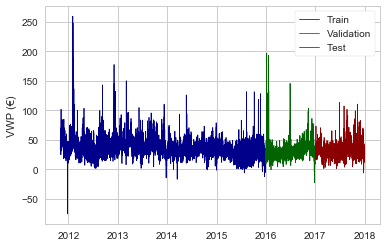

In [6]:
plt.figure()
plt.plot(df2["Win_VWP_Near"][:train_size], linewidth = 0.75, color = "darkblue")
plt.plot(df2["Win_VWP_Near"][train_size:-test_size], linewidth = 0.75, color = "darkgreen")
plt.plot(df2["Win_VWP_Near"][-test_size:], linewidth = 0.75, color = "darkred")
plt.legend(('Train', 'Validation', 'Test'), frameon = True, framealpha = 1)
plt.ylabel("VWP (€)")
plt.savefig("dataset_split.pdf")
plt.show()

## Common sense baselines: Validation
Mean Absolute Error (MAE) on the validation data for an apples-to-apples comparison. 

First, unstandardize the dataset:

In [7]:
df2n_unstd = np.copy(df2n)

df2n_unstd *= stdevs
df2n_unstd += means

targets = df2n_unstd[train_size:-test_size, headers.index("Win_VWP_Near")]

#### Predicting mean VWP from training set

In [8]:
print("MAE  €", round(np.mean(np.abs(targets - means[0])), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - means[0]))), 5))

MAE  € 9.00181
RMSE € 12.60574


#### Predicting system price of corresponding DeliveryHour

In [9]:
preds = df2n_unstd[train_size:-test_size, headers.index("Spot_PR_SP1")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.14593
RMSE € 7.53903


#### Predicting 6-hour lagged VWP (DeliveryHour 6 hours prior)
Assumed to represent the latest available information at the time of prediction.

In [10]:
preds = df2n_unstd[(train_size-6):-(test_size+6), headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 7.25657
RMSE € 12.27183


#### Predicting VWP of corresponding DeliveryHour of previous day

In [11]:
preds = df2n_unstd[(train_size-24):-(test_size+24), headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 5.31672
RMSE € 10.19886


#### Predicting SE3 price of corresponding DeliveryHour

In [12]:
preds = df2n_unstd[train_size:-test_size, headers.index("Spot_PR_SE3")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 2.95553
RMSE € 5.93879


#### Predicting "far" VWP of corresponding DeliveryHour

In [13]:
preds = df2n_unstd[train_size:-test_size, headers.index("Win_VWP_Far")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.80941
RMSE € 7.58732


## Common sense baselines: Test
Mean Absolute Error (MAE) on the test data for an apples-to-apples comparison of final model performance estimates. 

First, unstandardize the dataset:

In [16]:
targets = df2n_unstd[-test_size:, headers.index("Win_VWP_Near")]

#### Predicting mean VWP from training set

In [17]:
print("MAE  €", round(np.mean(np.abs(targets - means[0])), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - means[0]))), 5))

MAE  € 6.68287
RMSE € 9.26446


#### Predicting system price of corresponding DeliveryHour

In [18]:
preds = df2n_unstd[-test_size:, headers.index("Spot_PR_SP1")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.46757
RMSE € 7.0356


#### Predicting 6-hour lagged VWP (DeliveryHour 6 hours prior)
Assumed to represent the latest available information at the time of prediction.

In [19]:
preds = df2n_unstd[-test_size-6:-6, headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 7.16691
RMSE € 10.27575


#### Predicting VWP of corresponding DeliveryHour of previous day

In [20]:
preds = df2n_unstd[-test_size-24:-24, headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 6.02676
RMSE € 9.02005


#### Predicting SE3 price of corresponding DeliveryHour

In [21]:
preds = df2n_unstd[-test_size:, headers.index("Spot_PR_SE3")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 3.42779
RMSE € 5.64666


#### Predicting "far" VWP of corresponding DeliveryHour

In [22]:
preds = df2n_unstd[-test_size:, headers.index("Win_VWP_Far")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.00376
RMSE € 6.20141


## Generator function
#### Note: stored in Backend/timeseries.py so it can be easily imported elsewhere.

Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [9]:
def generator(data, lookback, min_index, max_index, delay = 0,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay
    # + 1 since include row of inputs for which to predict
    i = min_index + lookback + 1
    # while true
    while 1:
        if shuffle:
            # Pull batch_size random row indices between given index range
            rows = np.random.randint(
                min_index + lookback + 1, max_index, size=batch_size)
            # No i-counter since shuffling, so can repeat same rows
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback + 1
            # Define the row indices (observations) in batch
            rows = np.arange(i, min(i + batch_size, max_index))
            # Increment timeseries index counter
            i += len(rows)

        # Samples size = (batch_size, lookback_lags+1, num_features)
        ## +1 since we include the last set of inputs, i.e. those for which we want to predict
        samples = np.zeros((len(rows),
                           lookback+1 // step,
                           data.shape[-1]-1))
        # Outputs size = (batch_size)
        targets = np.zeros((len(rows),))
        # Iterate over row in rows (= j in batch)
        for j, row in enumerate(rows):
            # Indices = index of row j - lookback, to that row, by step
                # Gets row indices of lookback lags + "current" row j
            indices = range(rows[j] - lookback, rows[j]+1, step)
            # Get those ordered data observations
            # Each sample in batch has shape: (lookbacks, features)
            samples[j] = data[indices, 1:]
            # Corresponding targets are output [1] of row j + delay (24h)
                # In this case, outputs are in column [1]
            targets[j] = data[rows[j] + delay][0]
        # Sample shape: (batch_size, lookback_lags, num_features)
        # Targets shape: (batch_size,)
        yield samples, targets

Use the abstract generator function to instantiate three generators: one each for training, validation, and test.

In [10]:
# Look back 7 days of data
lookback = 7*24

# How many samples to include per batch
## Each sample is one row, lookback lags, and the output (delay = 0)
batch_size = 128

# Instantiate dataset generators
## Train is shuffled since each generated sample contains the lookback preceding observations
train_gen = generator(df2n,
                      lookback=lookback,
                      delay=0,
                      min_index=0,
                      max_index=train_size,
                      shuffle=True,
                      batch_size=batch_size)

val_gen = generator(df2n,
                    lookback=lookback,
                    delay=0,
                    min_index=train_size+1,
                    max_index=train_size+valid_size,
                    # shuffle=false by default
                    batch_size=batch_size)

test_gen = generator(df2n,
                     lookback=lookback,
                     delay=0,
                     min_index=train_size+valid_size+1,
                     max_index=None,
                     # shuffle=false by default
                     batch_size=batch_size)

# Number of steps to draw from train_gen
## It's shuffled, so train_steps iterations doesn't expose the full dataset
## This is just a useful rule of thumb as the batch and train sizes vary
train_steps = (train_size - lookback) // batch_size

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = ((train_size+valid_size) - (train_size+1) - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(df2n) - (train_size+valid_size+1) - lookback) // batch_size

## Deeper GRU with dropout

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model_gru2 = Sequential()
model_gru2.add(layers.GRU(64, 
                          dropout = 0.1,
                          recurrent_dropout = 0.3,
                          return_sequences = True,
                          input_shape=(None, df2n.shape[-1]-1)))
model_gru2.add(layers.GRU(128, 
                          dropout = 0.2,
                          recurrent_dropout = 0.4,
                          return_sequences = True))
model_gru2.add(layers.GRU(32, 
                          dropout = 0.1,
                          recurrent_dropout = 0.2,
                          activation = 'relu'))
model_gru2.add(layers.Dense(1))

model_gru2.compile(optimizer=RMSprop(), loss='mae')
history_gru2 = model_gru2.fit_generator(train_gen, 
                                   steps_per_epoch=train_steps, 
                                   epochs=50, 
                                   validation_data=val_gen, 
                                   validation_steps=val_steps)

Epoch 1/50
279/279 [==============================] - 155s 555ms/step - loss: 0.3057 - val_loss: 0.2221
Epoch 2/50
279/279 [==============================] - 148s 532ms/step - loss: 0.2647 - val_loss: 0.2036
Epoch 3/50
279/279 [==============================] - 148s 532ms/step - loss: 0.2549 - val_loss: 0.2011
Epoch 4/50
279/279 [==============================] - 149s 533ms/step - loss: 0.2458 - val_loss: 0.1896
Epoch 5/50
279/279 [==============================] - 149s 533ms/step - loss: 0.2375 - val_loss: 0.1947
Epoch 6/50
279/279 [==============================] - 148s 532ms/step - loss: 0.2318 - val_loss: 0.2029
Epoch 7/50
279/279 [==============================] - 148s 532ms/step - loss: 0.2317 - val_loss: 0.2010
Epoch 8/50
279/279 [==============================] - 148s 532ms/step - loss: 0.2276 - val_loss: 0.2131
Epoch 9/50
279/279 [==============================] - 149s 534ms/step - loss: 0.2246 - val_loss: 0.1878
Epoch 10/50
279/279 [==============================] - 148s 531m

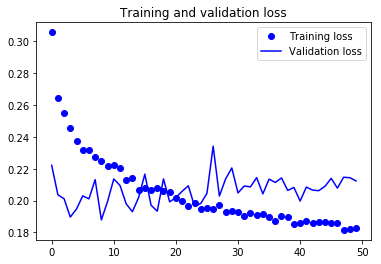

In [31]:
loss = history_gru2.history['loss']
val_loss = history_gru2.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Manually calculating MAE
model_fit_generator and model_evaluate_generator both seemingly reset the val_gen generator indexing, whereas model_predict_generator does not. As such, to make predictions starting at the beginning of the validation set (factoring in lookback window size etc.), we first have to re-initiate the generator to reset the indexing.

In [46]:
# Re-initiate generator
## Every time predict_generator is called, the generator continues (is not reset!)
val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size)

# Make predictions for the validation set using the (reset) generator
predictions = model_gru2.predict_generator(val_gen, steps = val_steps)
preds = np.reshape(predictions, (len(predictions),))

# Getting target outputs manually from validation set
## Have to +2 due to earlier indexing
targets1 = df2n_valid[lookback+2:lookback+2+len(predictions), 0]
print("Manual")
print(targets1[0:5])
print(np.mean(targets1))

# Getting target outputs via generator requires us to re-initiate the generator
val_gen = generator(df2n, lookback=lookback, min_index=train_size+1, max_index=train_size+valid_size)
targets2 = []
for step in range(val_steps):
    samples, targets = next(val_gen)
    targets2.append(targets)
targets2 = np.reshape(targets2, (len(predictions),))
print("\nGenerator")
print(targets2[0:5])
print(np.mean(targets2))

# Evaluate manually
print("\nManual MAE:   ", np.mean(np.abs(targets1 - preds)))

# Evaluate model using generator
## evaluate_generator resets the index, so no need to re-initiate
print("Generator MAE:", model_gru2.evaluate_generator(val_gen, steps = val_steps))

Manual
[-0.57831974 -0.7728707  -0.60111808 -0.57625412 -0.55345578]
-0.288385518926

Generator
[-0.57831974 -0.7728707  -0.60111808 -0.57625412 -0.55345578]
-0.288385518926

Manual MAE:    0.212309941073
Generator MAE: 0.212309940426


Does multiplying the MAE of standardized values with the training output standard deviation yield the true € measure?

In other words, is it equal to calculating the MAE of unscaled € predictions vs true values manually?

In [47]:
print("Un-standardizing model MAE: €", np.mean(np.abs(targets2 - preds))*stdevs[0])

p_us = np.copy(preds)
p_us *= stdevs[0]
p_us += means[0]

t_us2 = np.copy(targets2)
t_us2 *= stdevs[0]
t_us2 += means[0]

print("Un-standardizing model MAE: €", np.mean(np.abs(t_us2 - p_us)))

Un-standardizing model MAE: € 2.77512993285
Un-standardizing model MAE: € 2.7751300093


## Some first plots of validation set performance

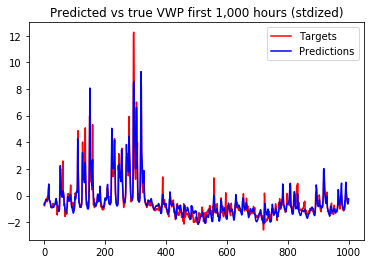

In [48]:
plt.figure()
plt.plot(range(1000), targets1[:1000], c = 'red', label='Targets')
plt.plot(range(1000), preds[:1000], c = 'blue', label='Predictions')
plt.title('Predicted vs true VWP first 1,000 hours (stdized)')
plt.legend()
plt.show()

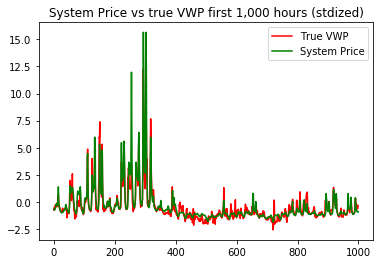

In [49]:
plt.figure()
plt.plot(range(1000), targets1[:1000], c = 'red', label='True VWP')
plt.plot(range(1000), df2n_valid[lookback+2:lookback+2+len(predictions), headers.index("Spot_PR_SP1")][:1000], c = 'green', label='System Price')
plt.title('System Price vs true VWP first 1,000 hours (stdized)')
plt.legend()
plt.show()

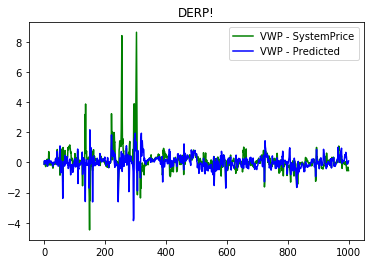

In [50]:
plt.figure()
plt.plot(range(1000), np.subtract(df2n_valid[lookback+2:lookback+2+len(predictions), headers.index("Spot_PR_SP1")][:1000], targets1[:1000]), c = 'green', label='VWP - SystemPrice')
plt.plot(range(1000), np.subtract(preds[:1000], targets1[:1000]), c = 'blue', label='VWP - Predicted')
plt.title('DERP!')
plt.legend()
plt.show()

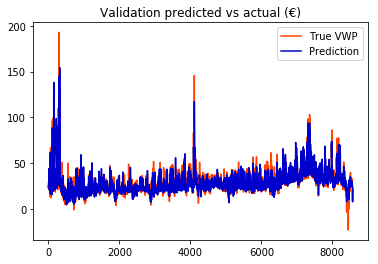

In [52]:
plt.figure()
plt.plot(range(len(preds)), np.add(targets1*stdevs[0], means[0]), c = 'orangered', label='True VWP')
plt.plot(range(len(preds)), np.add(preds*stdevs[0], means[0]), c = 'mediumblue', label='Prediction')
plt.title('Validation predicted vs actual (€)')
plt.legend()
plt.show()